In [1]:
import torch

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps"  if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using device: {device}")

if device.type == "cuda":
    idx = device.index or 0
    print("GPU name: ", torch.cuda.get_device_name(idx))
elif device.type == "mps":
    print("Running on Apple Silicon GPU via MPS")
else:
    print("Running on CPU")

Using device: mps
Running on Apple Silicon GPU via MPS


In [2]:
# Loading Dataset

import pandas as pd

try:
    df = pd.read_csv('final_beers_reviews_breweries.csv')
    print("\final Data Sample:")
    print(df.head())
except Exception as e:
    print(f"Error loading reviews.csv: {e}")

inal Data Sample:
              name state country                    style availability   abv  \
0  Older Viscosity    CA      US  American Imperial Stout     Rotating  12.0   
1  Older Viscosity    CA      US  American Imperial Stout     Rotating  12.0   
2  Older Viscosity    CA      US  American Imperial Stout     Rotating  12.0   
3  Older Viscosity    CA      US  American Imperial Stout     Rotating  12.0   
4  Older Viscosity    CA      US  American Imperial Stout     Rotating  12.0   

                                               notes  beer_id     username  \
0  Imperial Stout aged for 12 months in new bourb...    34094        Sazz9   
1  Imperial Stout aged for 12 months in new bourb...    34094  Amguerra305   
2  Imperial Stout aged for 12 months in new bourb...    34094      TheGent   
3  Imperial Stout aged for 12 months in new bourb...    34094         bobv   
4  Imperial Stout aged for 12 months in new bourb...    34094      Tony210   

         date  ...  look  smell

In [3]:
# Normalize rating-related columns to [0, 1] range to ensure consistent scale across features for training

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['look', 'smell', 'taste', 'feel', 'overall', 'score']] = scaler.fit_transform(
    df[[ 'look', 'smell', 'taste', 'feel', 'overall', 'score']]
)


In [4]:
df.describe()

,abv,beer_id,look,smell,taste,feel,overall,score
count,614525.000000,614525.000000,614525.000000,614525.000000,614525.000000,614525.000000,614525.000000,614525.000000
mean,7.582153,13682.230450,0.754612,0.736018,0.755178,0.738499,0.751018,0.748170
std,2.353999,20065.492805,0.142259,0.159482,0.163359,0.155050,0.158492,0.140153
min,2.500000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.600000,689.000000,0.687500,0.625000,0.687500,0.625000,0.687500,0.687500
50%,7.200000,2137.000000,0.750000,0.750000,0.750000,0.750000,0.750000,0.770000
75%,9.100000,21300.000000,0.875000,0.875000,0.875000,0.875000,0.875000,0.837500
max,18.000000,148052.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
######## UPDATED #########
# Preprocess the beer content features

# Preprocess beer content features
beerMeta = df[['beer_id', 'abv', 'style']].drop_duplicates().set_index('beer_id')

# Handle missing values - should not need since already cleaned at dataprocessing
# beerMeta['abv'] = beerMeta['abv'].fillna(beerMeta['abv'].mean())

# Encode categorical 'style'
from sklearn.preprocessing import LabelEncoder
style_encoder = LabelEncoder()
beerMeta['style_encoded'] = style_encoder.fit_transform(beerMeta['style'])

# Final feature tensor: abv + style_encoded
beerFeatureTensor = torch.tensor(
    beerMeta[['abv', 'style_encoded']].values,
    dtype=torch.float32
)

# Mapping beer_id to feature index
beerFeatureIndexMap = {beer_id: i for i, beer_id in enumerate(beerMeta.index)}

### Beer Content Feature Preprocessing

To enable hybrid recommendations, we incorporated beer-specific content features into the model. Below are the steps used to prepare these features:

#### 1. Extract Beer Metadata
We extracted:
- `beer_id`: Unique identifier
- `abv`: Alcohol by volume
- `style`: Beer type (e.g., IPA, Lager)

Duplicates were removed to ensure one entry per beer.

#### 2. Handle Missing ABV Values
Missing values in `abv` were imputed using the mean:
$$
\text{abv}_{\text{missing}} = \frac{1}{N} \sum_{i=1}^N \text{abv}_i
$$

#### 3. Encode Categorical Style
The `style` column was label-encoded:
$$
\text{style}_{\text{encoded}} = \text{LabelEncoder}(\text{style})
$$

#### 4. Construct Feature Tensor
We created a PyTorch tensor from:
- Continuous: `abv`
- Categorical: `style_encoded`

This yields a feature matrix:
$$
\mathbf{F} \in \mathbb{R}^{n \times 2}, \quad \text{where } n = \text{number of beers}
$$

#### 5. Feature Index Mapping
A dictionary was built:
$$
\text{beerFeatureIndexMap}[ \text{beer\_id} ] = \text{row index in } \mathbf{F}
$$

---

These engineered features enhance the model’s ability to generalize and make content-aware predictions, especially in cold-start scenarios.


In [6]:
# Map usernames and beer IDs to integer indices for embedding lookup

from sklearn.model_selection import train_test_split

# Create mapping dictionaries for users and beers
users = df['username'].unique()
userIndexDict = {user: idx for idx, user in enumerate(users)}

beers = df['beer_id'].unique()
beerIndexDict = {beer: idx for idx, beer in enumerate(beers)}

# Map the original columns to new index columns
df['userIndex'] = df['username'].map(userIndexDict)
df['beerIndex'] = df['beer_id'].map(beerIndexDict)

print("Number of unique users:", len(userIndexDict))
print("Number of unique beers:", len(beerIndexDict))

Number of unique users: 15894
Number of unique beers: 500


In [7]:
# Split the data (e.g., 80% training, 20% validation)
trainDf, valDf = train_test_split(df, test_size=0.2, random_state=42)

print("Training set shape:", trainDf.shape)
print("Validation set shape:", valDf.shape)


Training set shape: (491620, 23)
Validation set shape: (122905, 23)


In [8]:
# Define a PyTorch Dataset class to return user, beer, and score tensors for each sample

import torch
from torch.utils.data import Dataset

# class BeerDataset(Dataset):
#     def __init__(self, df):
#         self.user_ids = df['userIndex'].values
#         self.beer_ids = df['beerIndex'].values
#         self.scores = df['score'].values.astype('float32')
    
#     def __len__(self):
#         return len(self.scores)
    
#     def __getitem__(self, idx):
#         return {
#             'user': torch.tensor(self.user_ids[idx], dtype=torch.long),
#             'beer': torch.tensor(self.beer_ids[idx], dtype=torch.long),
#             'score': torch.tensor(self.scores[idx], dtype=torch.float)
#         }

# trainDataset = BeerDataset(trainDf)
# valDataset = BeerDataset(valDf)

#### UPDATED #####
class BeerDataset(Dataset):
    def __init__(self, df, featureIndexMap):
        self.user_ids = df['userIndex'].values
        self.beer_ids = df['beerIndex'].values
        self.scores = df['score'].values.astype('float32')
        self.feature_indices = df['beer_id'].map(featureIndexMap).values

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        return {
            'user': torch.tensor(self.user_ids[idx], dtype=torch.long),
            'beer': torch.tensor(self.beer_ids[idx], dtype=torch.long),
            'feature_idx': torch.tensor(self.feature_indices[idx], dtype=torch.long),
            'score': torch.tensor(self.scores[idx], dtype=torch.float)
        }
trainDataset = BeerDataset(trainDf, beerFeatureIndexMap)
valDataset = BeerDataset(valDf, beerFeatureIndexMap)


In [9]:
# Create DataLoaders to batch and shuffle training data, and batch validation data (no shuffling)
# The model will process 256 samples at a time.
# Shuffles training data each epoch to improve generalization.
# Keeps validation data in fixed order (standard practice).

from torch.utils.data import DataLoader

trainLoader = DataLoader(trainDataset, batch_size=256, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=256, shuffle=False)


In [10]:
###### UPDATED ####### HYBRID with features
import torch.nn as nn

class MF_Recommender(nn.Module):
    def __init__(self, num_users, num_beers, num_content_features, embedding_dim=32):
        super(MF_Recommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.beer_embedding = nn.Embedding(num_beers, embedding_dim)
        
        self.user_bias = nn.Embedding(num_users, 1)
        self.beer_bias = nn.Embedding(num_beers, 1)
        self.global_bias = nn.Parameter(torch.tensor(0.0))

        nn.init.normal_(self.user_embedding.weight, 0, 0.1)
        nn.init.normal_(self.beer_embedding.weight, 0, 0.1)
        nn.init.constant_(self.user_bias.weight, 0.0)
        nn.init.constant_(self.beer_bias.weight, 0.0)

        # Beer content feature encoder
        self.beer_content_fc = nn.Sequential(
            nn.Linear(num_content_features, 16),  # e.g., 2 for [abv, style_encoded]
            nn.ReLU()
        )

        # Final prediction layer
        self.output_layer = nn.Linear(1 + 16, 1)
        
    def forward(self, user, beer, feature_idx, beer_features):
        user_emb = self.user_embedding(user)       # (batch, embed_dim)
        beer_emb = self.beer_embedding(beer)       # (batch, embed_dim)
        interaction = (user_emb * beer_emb).sum(dim=1, keepdim=True)  # (batch, 1)

        # Lookup and encode content features
        beer_content = beer_features[feature_idx]  # (batch, num_content_features)
        beer_content_emb = self.beer_content_fc(beer_content)

        # Concatenate interaction + content encoding
        x = torch.cat([interaction, beer_content_emb], dim=1)
        rating = self.output_layer(x).squeeze(1)

        # Add bias
        u_bias = self.user_bias(user).squeeze(1)
        b_bias = self.beer_bias(beer).squeeze(1)
        rating = rating + u_bias + b_bias + self.global_bias

        # Clamp between 0 and 1
        rating = rating.clamp(min=0.0, max=1.0)
        return rating

# Initialize model parameters
userCount = len(userIndexDict)
beerCount = len(beerIndexDict)
num_content_features = beerFeatureTensor.shape[1]  # Automatically get number of beer features

mf_model = MF_Recommender(
    num_users=userCount,
    num_beers=beerCount,
    num_content_features=num_content_features,
    embedding_dim=32
)

mf_model = mf_model.to(device)

for name, param in mf_model.named_parameters():
    print(name, tuple(param.shape), param.requires_grad)

global_bias () True
user_embedding.weight (15894, 32) True
beer_embedding.weight (500, 32) True
user_bias.weight (15894, 1) True
beer_bias.weight (500, 1) True
beer_content_fc.0.weight (16, 2) True
beer_content_fc.0.bias (16,) True
output_layer.weight (1, 17) True
output_layer.bias (1,) True


In [11]:
###### UPDATED ####### HYBRID with features

import torch.nn as nn

class NonLinear_MF_Recommender(nn.Module):
    def __init__(self, num_users, num_beers, num_content_features, embedding_dim=32, hidden_dim=64):
        super(NonLinear_MF_Recommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.beer_embedding = nn.Embedding(num_beers, embedding_dim)
        
        self.user_bias = nn.Embedding(num_users, 1)
        self.beer_bias = nn.Embedding(num_beers, 1)

        # Beer content feature encoder
        self.beer_content_fc = nn.Sequential(
            nn.Linear(num_content_features, 16),
            nn.ReLU()
        )

        # Update input size: user + beer + beer_content
        self.fc1 = nn.Linear(2 * embedding_dim + 16, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

        # Initialization
        nn.init.normal_(self.user_embedding.weight, 0, 0.1)
        nn.init.normal_(self.beer_embedding.weight, 0, 0.1)
        nn.init.constant_(self.user_bias.weight, 0.0)
        nn.init.constant_(self.beer_bias.weight, 0.0)

    def forward(self, user, beer, feature_idx, beer_features):
        user_emb = self.user_embedding(user)
        beer_emb = self.beer_embedding(beer)
        beer_content = beer_features[feature_idx]
        beer_content_emb = self.beer_content_fc(beer_content)

        x = torch.cat([user_emb, beer_emb, beer_content_emb], dim=1)
        h = torch.relu(self.fc1(x))
        rating = self.fc2(h).squeeze(1)

        u_bias = self.user_bias(user).squeeze(1)
        b_bias = self.beer_bias(beer).squeeze(1)
        rating = rating + u_bias + b_bias
        rating = rating.clamp(min=0.0, max=1.0)

        return rating

num_content_features = beerFeatureTensor.shape[1]

nonlinear_mf_model = NonLinear_MF_Recommender(
    num_users=userCount,
    num_beers=beerCount,
    num_content_features=num_content_features,
    embedding_dim=32,
    hidden_dim=64
)

nonlinear_mf_model = nonlinear_mf_model.to(device)

for name, param in nonlinear_mf_model.named_parameters():
    print(name, tuple(param.shape), param.requires_grad)



user_embedding.weight (15894, 32) True
beer_embedding.weight (500, 32) True
user_bias.weight (15894, 1) True
beer_bias.weight (500, 1) True
beer_content_fc.0.weight (16, 2) True
beer_content_fc.0.bias (16,) True
fc1.weight (64, 80) True
fc1.bias (64,) True
fc2.weight (1, 64) True
fc2.bias (1,) True


In [12]:
###### UPDATED ####### HYBRID with features

import torch.nn as nn

class NeuMF_Recommender(nn.Module):
    def __init__(self, num_users, num_beers, num_content_features, gmf_dim=32, mlp_dim=32, mlp_layers=[64, 32]):
        super(NeuMF_Recommender, self).__init__()
        self.gmf_user_embedding = nn.Embedding(num_users, gmf_dim)
        self.gmf_beer_embedding = nn.Embedding(num_beers, gmf_dim)

        self.mlp_user_embedding = nn.Embedding(num_users, mlp_dim)
        self.mlp_beer_embedding = nn.Embedding(num_beers, mlp_dim)

        self.user_bias = nn.Embedding(num_users, 1)
        self.beer_bias = nn.Embedding(num_beers, 1)

        # Encode beer content
        self.beer_content_fc = nn.Sequential(
            nn.Linear(num_content_features, 16),
            nn.ReLU()
        )

        # MLP layers for MLP branch
        mlp_modules = []
        input_size = 2 * mlp_dim
        for h in mlp_layers:
            mlp_modules += [nn.Linear(input_size, h), nn.ReLU(), nn.Dropout(0.2)]
            input_size = h
        self.mlp = nn.Sequential(*mlp_modules)

        # Final fusion layer includes GMF + MLP + beer_content
        final_dim = gmf_dim + mlp_layers[-1] + 16
        self.predict_layer = nn.Linear(final_dim, 1, bias=True)

        # Initialize weights
        nn.init.normal_(self.gmf_user_embedding.weight, 0, 0.1)
        nn.init.normal_(self.gmf_beer_embedding.weight, 0, 0.1)
        nn.init.normal_(self.mlp_user_embedding.weight, 0, 0.1)
        nn.init.normal_(self.mlp_beer_embedding.weight, 0, 0.1)
        nn.init.constant_(self.user_bias.weight, 0.0)
        nn.init.constant_(self.beer_bias.weight, 0.0)

    def forward(self, user, beer, feature_idx, beer_features):
        # GMF branch
        gmf_user = self.gmf_user_embedding(user)
        gmf_beer = self.gmf_beer_embedding(beer)
        gmf_out = gmf_user * gmf_beer  # (batch, gmf_dim)

        # MLP branch
        mlp_user = self.mlp_user_embedding(user)
        mlp_beer = self.mlp_beer_embedding(beer)
        mlp_in = torch.cat([mlp_user, mlp_beer], dim=1)
        mlp_out = self.mlp(mlp_in)  # (batch, mlp_layers[-1])

        # Beer content
        beer_content = beer_features[feature_idx]
        beer_content_emb = self.beer_content_fc(beer_content)  # (batch, 16)

        # Final fusion and prediction
        x = torch.cat([gmf_out, mlp_out, beer_content_emb], dim=1)
        out = self.predict_layer(x).squeeze(1)

        user_bias = self.user_bias(user).squeeze(1)
        beer_bias = self.beer_bias(beer).squeeze(1)
        rating = out + user_bias + beer_bias
        rating = rating.clamp(min=0.0, max=1.0)

        return rating

# Initialize model parameters
userCount = len(userIndexDict)
beerCount = len(beerIndexDict)
num_content_features = beerFeatureTensor.shape[1]  # Automatically get number of beer features

neu_mf_model = NeuMF_Recommender(
    num_users=userCount,
    num_beers=beerCount,
    num_content_features=num_content_features,
    gmf_dim=64,
    mlp_dim=64,
    mlp_layers=[128, 64, 32, 16]
)

neu_mf_model = neu_mf_model.to(device)

for name, param in neu_mf_model.named_parameters():
    print(name, tuple(param.shape), param.requires_grad)

gmf_user_embedding.weight (15894, 64) True
gmf_beer_embedding.weight (500, 64) True
mlp_user_embedding.weight (15894, 64) True
mlp_beer_embedding.weight (500, 64) True
user_bias.weight (15894, 1) True
beer_bias.weight (500, 1) True
beer_content_fc.0.weight (16, 2) True
beer_content_fc.0.bias (16,) True
mlp.0.weight (128, 128) True
mlp.0.bias (128,) True
mlp.3.weight (64, 128) True
mlp.3.bias (64,) True
mlp.6.weight (32, 64) True
mlp.6.bias (32,) True
mlp.9.weight (16, 32) True
mlp.9.bias (16,) True
predict_layer.weight (1, 96) True
predict_layer.bias (1,) True


In [13]:
###### UPDATED #######
# To accept beer features
# Arguments:
        # model (nn.Module): The hybrid recommender model
        # trainLoader (DataLoader): DataLoader for training data
        # beerFeatureTensor (Tensor): Tensor of beer content features
        # lr (float): Learning rate for optimizer
        # weight_decay (float): Weight decay
        # num_epochs (int): Number of training epochs

import torch.optim as optim
import matplotlib.pyplot as plt

def trainModel(model, trainLoader, beerFeatureTensor, lr, weight_decay, num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    losses = []
    beerFeatureTensor = beerFeatureTensor.to(device)  # Ensure on same device as model
    
    for epoch in range(num_epochs):
        model.train()
        totalLoss = 0.0
        
        for batch in trainLoader:
            user = batch['user'].to(device)
            beer = batch['beer'].to(device)
            rating = batch['score'].to(device)
            feature_idx = batch['feature_idx'].to(device)  # <- NEW for hybrid

            optimizer.zero_grad()
            predictions = model(user, beer, feature_idx, beerFeatureTensor)
            loss = criterion(predictions, rating)
            loss.backward()
            optimizer.step()

            totalLoss += loss.item()
        
        avgLoss = totalLoss / len(trainLoader)
        losses.append(avgLoss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avgLoss:.4f}")
    
    # Visualize training loss
    plt.plot(losses)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


In [14]:
###### UPDATED #######
# Arguments:
        # model (nn.Module): Trained model
        # valLoader (DataLoader): Validation DataLoader
        # beerFeatureTensor (Tensor): Tensor of beer content features
        # valDataset (Dataset): The actual validation dataset (for size)

def evalModel(model, valLoader, beerFeatureTensor, valDataset):
    model.to(device)
    model.eval()
    totalValLoss = 0.0
    criterion = nn.MSELoss()
    beerFeatureTensor = beerFeatureTensor.to(device)

    with torch.no_grad():
        for batch in valLoader:
            user = batch['user'].to(device)
            beer = batch['beer'].to(device)
            rating = batch['score'].to(device)
            feature_idx = batch['feature_idx'].to(device)  # <-- NEW

            predictions = model(user, beer, feature_idx, beerFeatureTensor)
            loss = criterion(predictions, rating)
            totalValLoss += loss.item() * rating.size(0)

    avgValLoss = totalValLoss / len(valDataset)
    rmse = avgValLoss ** 0.5

    print(f"Validation MSE: {avgValLoss:.4f}")
    print(f"Validation RMSE: {rmse:.4f}")
    return avgValLoss, rmse


Model: mf_model
Epoch 1/50, Loss: 0.2976
Epoch 2/50, Loss: 0.0281
Epoch 3/50, Loss: 0.0131
Epoch 4/50, Loss: 0.0114
Epoch 5/50, Loss: 0.0109
Epoch 6/50, Loss: 0.0107
Epoch 7/50, Loss: 0.0106
Epoch 8/50, Loss: 0.0105
Epoch 9/50, Loss: 0.0102
Epoch 10/50, Loss: 0.0101
Epoch 11/50, Loss: 0.0100
Epoch 12/50, Loss: 0.0099
Epoch 13/50, Loss: 0.0098
Epoch 14/50, Loss: 0.0098
Epoch 15/50, Loss: 0.0098
Epoch 16/50, Loss: 0.0098
Epoch 17/50, Loss: 0.0098
Epoch 18/50, Loss: 0.0097
Epoch 19/50, Loss: 0.0097
Epoch 20/50, Loss: 0.0097
Epoch 21/50, Loss: 0.0097
Epoch 22/50, Loss: 0.0097
Epoch 23/50, Loss: 0.0097
Epoch 24/50, Loss: 0.0097
Epoch 25/50, Loss: 0.0097
Epoch 26/50, Loss: 0.0097
Epoch 27/50, Loss: 0.0097
Epoch 28/50, Loss: 0.0097
Epoch 29/50, Loss: 0.0097
Epoch 30/50, Loss: 0.0097
Epoch 31/50, Loss: 0.0097
Epoch 32/50, Loss: 0.0097
Epoch 33/50, Loss: 0.0097
Epoch 34/50, Loss: 0.0097
Epoch 35/50, Loss: 0.0097
Epoch 36/50, Loss: 0.0097
Epoch 37/50, Loss: 0.0097
Epoch 38/50, Loss: 0.0097
Epoch

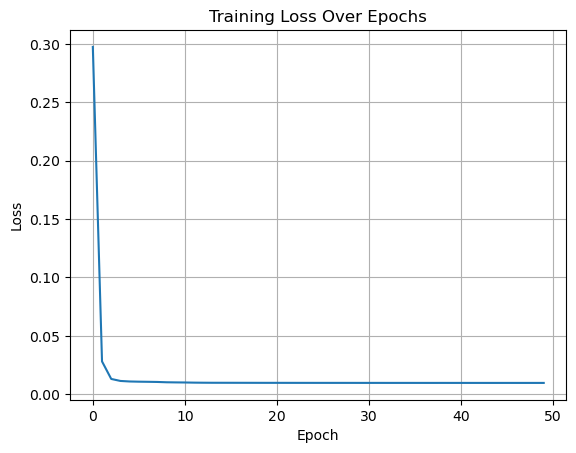

Validation MSE: 0.0102
Validation RMSE: 0.1012


(0.010232789559410828, 0.10115725164025972)

In [15]:
print("Model: mf_model")
# trainModel(mf_model)
# evalModel(mf_model)

trainModel(mf_model, trainLoader, beerFeatureTensor, lr=1e-4, weight_decay=1e-5, num_epochs=50)
evalModel(mf_model, valLoader, beerFeatureTensor, valDataset)

Model: nonlinear_mf_model
Epoch 1/50, Loss: 0.0319
Epoch 2/50, Loss: 0.0115
Epoch 3/50, Loss: 0.0110
Epoch 4/50, Loss: 0.0106
Epoch 5/50, Loss: 0.0104
Epoch 6/50, Loss: 0.0104
Epoch 7/50, Loss: 0.0103
Epoch 8/50, Loss: 0.0102
Epoch 9/50, Loss: 0.0098
Epoch 10/50, Loss: 0.0097
Epoch 11/50, Loss: 0.0097
Epoch 12/50, Loss: 0.0097
Epoch 13/50, Loss: 0.0097
Epoch 14/50, Loss: 0.0096
Epoch 15/50, Loss: 0.0096
Epoch 16/50, Loss: 0.0096
Epoch 17/50, Loss: 0.0096
Epoch 18/50, Loss: 0.0095
Epoch 19/50, Loss: 0.0095
Epoch 20/50, Loss: 0.0095
Epoch 21/50, Loss: 0.0095
Epoch 22/50, Loss: 0.0095
Epoch 23/50, Loss: 0.0094
Epoch 24/50, Loss: 0.0094
Epoch 25/50, Loss: 0.0094
Epoch 26/50, Loss: 0.0094
Epoch 27/50, Loss: 0.0094
Epoch 28/50, Loss: 0.0093
Epoch 29/50, Loss: 0.0093
Epoch 30/50, Loss: 0.0092
Epoch 31/50, Loss: 0.0092
Epoch 32/50, Loss: 0.0092
Epoch 33/50, Loss: 0.0092
Epoch 34/50, Loss: 0.0092
Epoch 35/50, Loss: 0.0091
Epoch 36/50, Loss: 0.0091
Epoch 37/50, Loss: 0.0091
Epoch 38/50, Loss: 0.

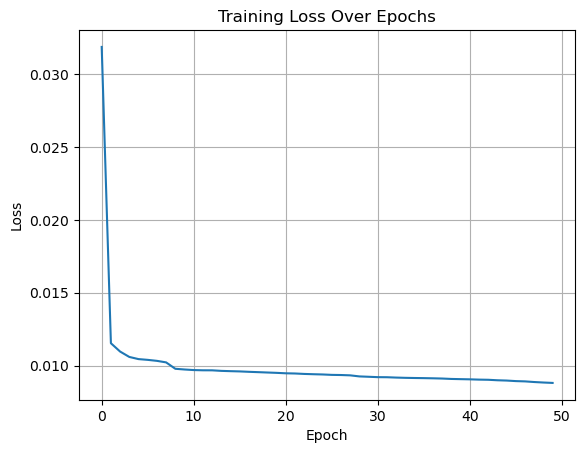

Validation MSE: 0.0103
Validation RMSE: 0.1014


(0.010286011925077575, 0.10141997793865652)

In [16]:
print("Model: nonlinear_mf_model")
# trainModel(nonlinear_mf_model)
# evalModel(nonlinear_mf_model)

trainModel(nonlinear_mf_model, trainLoader, beerFeatureTensor, lr=1e-4, weight_decay=1e-5, num_epochs=50)
evalModel(nonlinear_mf_model, valLoader, beerFeatureTensor, valDataset)

Model: neu_mf_model
Epoch 1/50, Loss: 0.0177
Epoch 2/50, Loss: 0.0121
Epoch 3/50, Loss: 0.0114
Epoch 4/50, Loss: 0.0111
Epoch 5/50, Loss: 0.0108
Epoch 6/50, Loss: 0.0106
Epoch 7/50, Loss: 0.0105
Epoch 8/50, Loss: 0.0103
Epoch 9/50, Loss: 0.0100
Epoch 10/50, Loss: 0.0099
Epoch 11/50, Loss: 0.0098
Epoch 12/50, Loss: 0.0097
Epoch 13/50, Loss: 0.0096
Epoch 14/50, Loss: 0.0096
Epoch 15/50, Loss: 0.0095
Epoch 16/50, Loss: 0.0095
Epoch 17/50, Loss: 0.0095
Epoch 18/50, Loss: 0.0094
Epoch 19/50, Loss: 0.0094
Epoch 20/50, Loss: 0.0093
Epoch 21/50, Loss: 0.0093
Epoch 22/50, Loss: 0.0093
Epoch 23/50, Loss: 0.0092
Epoch 24/50, Loss: 0.0092
Epoch 25/50, Loss: 0.0092
Epoch 26/50, Loss: 0.0091
Epoch 27/50, Loss: 0.0091
Epoch 28/50, Loss: 0.0090
Epoch 29/50, Loss: 0.0090
Epoch 30/50, Loss: 0.0089
Epoch 31/50, Loss: 0.0089
Epoch 32/50, Loss: 0.0088
Epoch 33/50, Loss: 0.0088
Epoch 34/50, Loss: 0.0087
Epoch 35/50, Loss: 0.0087
Epoch 36/50, Loss: 0.0087
Epoch 37/50, Loss: 0.0086
Epoch 38/50, Loss: 0.0085
E

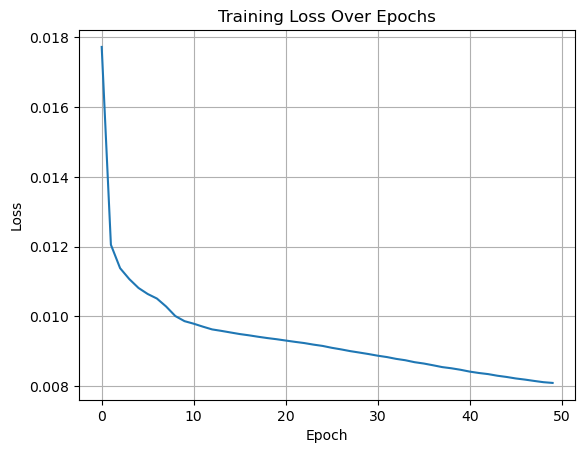

Validation MSE: 0.0107
Validation RMSE: 0.1035


(0.01071527887731039, 0.1035146312233705)

In [15]:
print("Model: neu_mf_model")
# trainModel(neu_mf_model)
# evalModel(neu_mf_model)

trainModel(neu_mf_model, trainLoader, beerFeatureTensor, lr=1e-4, weight_decay=1e-5, num_epochs=50)
evalModel(neu_mf_model, valLoader, beerFeatureTensor, valDataset)

In [34]:
# utility functions and datafames

# Inverse mappings
indexBeerDict = {index: beer for beer, index in beerIndexDict.items()}
indexUserMap = {index: user for user, index in userIndexDict.items()}

def topKRecommendedBeersForUser(model, userIndex, beerFeatureTensor, topK=10):

    model.to(device)
    model.eval()
    allBeerIndices = torch.arange(len(beerIndexDict)).to(device)
    userTensor = torch.tensor([userIndex] * len(beerIndexDict), dtype=torch.long).to(device)
    # Feature indices are same as beer indices (1-to-1 mapping assumed)
    beerFeatureIndices = allBeerIndices
    with torch.no_grad():
        predictedRatings = model(userTensor, allBeerIndices, beerFeatureIndices, beerFeatureTensor.to(device))
    topRatings, topBeerIndices = torch.topk(predictedRatings, topK)
    recommendedBeers = [indexBeerDict[index.item()] for index in topBeerIndices]
    return recommendedBeers,topRatings

beerDetails = df.groupby('beer_id').agg({
    'name': 'first',
    'state': 'first',
    'country': 'first',
    'style': 'first',
    'availability': 'first',
    'abv': 'mean',
    'notes': 'first',
    'look': 'mean',
    'smell': 'mean',
    'taste': 'mean',
    'feel': 'mean',
    'overall': 'mean',
    'score': 'mean',
    'name_brewery': 'first',
    'city': 'first',
    'notes_brewery': 'first',
    'types': 'first'
}).reset_index()

def getBeerDetailsFromIds(beerIdList):
    df_idx = beerDetails.set_index('beer_id')
    df_out = df_idx.loc[beerIdList]
    return df_out.reset_index()

def getBeerDetailsFromIdsWithPredictedScore(beerIdList, predictedScores):
    df_beerDetails = getBeerDetailsFromIds(beerIdList)[['name', 'style', 'abv', 'score']]
    scores = predictedScores.detach().cpu().tolist()
    df_beerDetails['predicted_user_score'] = scores
    return df_beerDetails
    
def getActualTopKReviewedBeersForUser(username, topK=10):
    userReviews = df[df['username'] == username]
    return userReviews.sort_values(by='score', ascending=False).head(topK)

def getUsername(userIndex):
    username = indexUserMap.get(userIndex, "Unknown User")
    print(f"Username for user index {userIndex}: {username}")
    return username


In [14]:
# For a given user index get the actual top K reviewed beers:
userIndex = 8180
username = getUsername(userIndex)
topK = 5
print(f"Username for user index {userIndex}: {username}")
getActualTopKReviewedBeersForUser(username, topK)

Username for user index 8180: 86MonteSS
Username for user index 10: 86MonteSS


,name,state,country,style,availability,abv,notes,beer_id,username,date,...,taste,feel,overall,score,name_brewery,city,notes_brewery,types,userIndex,beerIndex
388790,Trappistes Rochefort 10,Namur,BE,Belgian Quadrupel (Quad),Year-round,11.3,No notes at this time.,645,86MonteSS,2003-04-21,...,1.000,0.875,1.000,0.9800,Brasserie de Rochefort,Rochefort,No notes at this time.,Brewery,8180,307
390655,Trappistes Rochefort 8,Namur,BE,Belgian Strong Dark Ale,Year-round,9.2,No notes at this time.,1696,86MonteSS,2003-05-16,...,1.000,0.875,1.000,0.9800,Brasserie de Rochefort,Rochefort,No notes at this time.,Brewery,8180,308
412661,Abt 12,West Flanders,BE,Belgian Quadrupel (Quad),Year-round,10.0,No notes at this time.,1708,86MonteSS,2003-11-06,...,0.875,0.875,1.000,0.9375,Brouwerij St. Bernardus NV,Watou,No notes at this time.,Brewery,8180,324
491497,Golden Monkey,PA,US,Belgian Tripel,Year-round,9.5,"A magical, mystical Monkey whose golden sole g...",1003,86MonteSS,2003-10-07,...,1.000,1.000,1.000,0.9250,Victory Brewing Company - Downingtown,Downingtown,No notes at this time.,"Brewery, Bar, Eatery, Beer-to-go",8180,389
369872,Imperial Stout,GB2,GB,Russian Imperial Stout,Year-round,7.0,No notes at this time.,782,86MonteSS,2003-04-21,...,0.875,1.000,0.875,0.9250,Samuel Smith Old Brewery (Tadcaster),Tadcaster,No notes at this time.,"Brewery, Beer-to-go",8180,291


In [27]:
userIndex = 8180
topK = 10
username = getUsername(userIndex)

print(f"Username for user index {userIndex}: {username}\n")

print("Actual Top-Rated Beers by User:")
print(getActualTopKReviewedBeersForUser(username, topK)[['name', 'style', 'score']])

print("\n mf_model Top-K Predicted Recommendations:")
recommended_beer_ids,topRatings = topKRecommendedBeersForUser(mf_model, userIndex, beerFeatureTensor, topK=topK)
print(getBeerDetailsFromIdsWithPredictedScore(recommended_beer_ids,topRatings).to_string(index=False))

# print("=================\n")
print("\n nonlinear_mf_model Top-K Predicted Recommendations:")
recommended_beer_ids,topRatings = topKRecommendedBeersForUser(nonlinear_mf_model, userIndex, beerFeatureTensor, topK=topK)
print(getBeerDetailsFromIdsWithPredictedScore(recommended_beer_ids,topRatings).to_string(index=False))

print("=================\n")
print("\n neu_mf_model Top-K Predicted Recommendations:")
recommended_beer_ids,topRatings = topKRecommendedBeersForUser(neu_mf_model, userIndex, beerFeatureTensor, topK=topK)
print(getBeerDetailsFromIdsWithPredictedScore(recommended_beer_ids,topRatings).to_string(index=False))

Username for user index 8180: 86MonteSS
Username for user index 8180: 86MonteSS

Actual Top-Rated Beers by User:
                           name                     style   score
388790  Trappistes Rochefort 10  Belgian Quadrupel (Quad)  0.9800
390655   Trappistes Rochefort 8   Belgian Strong Dark Ale  0.9800
412661                   Abt 12  Belgian Quadrupel (Quad)  0.9375
491497            Golden Monkey            Belgian Tripel  0.9250
369872           Imperial Stout    Russian Imperial Stout  0.9250
465572            Bass Pale Ale          English Pale Ale  0.9200
141674         Spaten Optimator         German Doppelbock  0.9125
222971         World Wide Stout   American Imperial Stout  0.9100
352636             Old Rasputin    Russian Imperial Stout  0.9050
500260         Storm King Stout   American Imperial Stout  0.9000

 mf_model Top-K Predicted Recommendations:
                                                      name                   style   abv    score  predicted_score
  

In [35]:
# MF model recommendations ##### UPDATED #####
recommended_mf,recommended_mf_topRatings  = topKRecommendedBeersForUser(mf_model, userIndex, beerFeatureTensor, topK)
recommended_mf_names  = getBeerDetailsFromIds(recommended_mf)
print("mf_model - Recommended beer IDs:", recommended_mf)
print("mf_model - Recommended beers:")
print(getBeerDetailsFromIdsWithPredictedScore(recommended_mf,recommended_mf_topRatings).to_string(index=False))

mf_model - Recommended beer IDs: [34094, 31613, 33243, 31323, 3280, 224, 1934, 37774, 7438, 39]
mf_model - Recommended beers:
                                                      name                   style   abv    score  predicted_user_score
                                           Older Viscosity American Imperial Stout 12.00 0.826626                   0.0
                                             Old Viscosity American Imperial Stout 10.00 0.783706                   0.0
                                               Wipeout IPA            American IPA  7.50 0.768818                   0.0
                                                    Hop 15   American Imperial IPA 10.00 0.793030                   0.0
                     Schneider Weisse Tap 7 Unser Original       German Hefeweizen  5.40 0.743155                   0.0
                    Schneider Weisse Tap 6 Unser Aventinus       German Weizenbock  8.20 0.825186                   0.0
                        Schneider 

In [36]:
# Non-linear MF model recommendations ##### UPDATED #####
recommended_nl, recommended_nl_topRatings = topKRecommendedBeersForUser(nonlinear_mf_model, userIndex, beerFeatureTensor, topK)
recommended_nl_names = getBeerDetailsFromIds(recommended_nl)
print("nonlinear_mf_model - Recommended beer IDs:", recommended_nl)
print("nonlinear_mf_model - Recommendeded beers:")
print(getBeerDetailsFromIdsWithPredictedScore(recommended_nl,recommended_nl_topRatings).to_string(index=False))

nonlinear_mf_model - Recommended beer IDs: [1576, 7520, 2178, 1881, 104, 577, 2081, 1769, 171, 7463]
nonlinear_mf_model - Recommendeded beers:
                         name                  style  abv    score  predicted_user_score
                Christmas Ale          Winter Warmer  7.5 0.726010              0.930292
     Dark Lord Imperial Stout Russian Imperial Stout 15.0 0.818243              0.921909
                     Jubelale          Winter Warmer  6.7 0.735194              0.916140
Samuel Adams Old Fezziwig Ale          Winter Warmer  5.9 0.701330              0.915149
    Samuel Adams Boston Lager           Vienna Lager  5.0 0.704570              0.908649
           Winter Welcome Ale          Winter Warmer  6.0 0.660282              0.906911
 Winter Solstice Seasonal Ale          Winter Warmer  6.9 0.710772              0.902545
        Alaskan Smoked Porter           Smoke Porter  6.5 0.795301              0.899997
        Dos Equis Amber Lager           Vienna Lager  4.

In [33]:
# NeuMF model recommendations ##### UPDATED #####
recommended_neu, recommended_neu_topRatings = topKRecommendedBeersForUser(neu_mf_model, userIndex, beerFeatureTensor, topK)
recommended_neu_names = getBeerDetailsFromIds(recommended_neu)
print("neu_mf_model - Recommended beer IDs:", recommended_neu)
print("neu_mf_model - Recommendeded beers :")
print(getBeerDetailsFromIdsWithPredictedScore(recommended_nl,recommended_neu_topRatings).to_string(index=False))

neu_mf_model - Recommended beer IDs: [9086, 2392, 6533, 10672, 33832, 2965, 94350, 1009, 57747, 1579]
neu_mf_model - Recommendeded beers :
                         name                  style  abv    score  predicted_score
                Christmas Ale          Winter Warmer  7.5 0.726010         0.393786
     Dark Lord Imperial Stout Russian Imperial Stout 15.0 0.818243         0.368214
                     Jubelale          Winter Warmer  6.7 0.735194         0.336736
Samuel Adams Old Fezziwig Ale          Winter Warmer  5.9 0.701330         0.232151
    Samuel Adams Boston Lager           Vienna Lager  5.0 0.704570         0.219365
           Winter Welcome Ale          Winter Warmer  6.0 0.660282         0.215184
 Winter Solstice Seasonal Ale          Winter Warmer  6.9 0.710772         0.198566
        Alaskan Smoked Porter           Smoke Porter  6.5 0.795301         0.196140
        Dos Equis Amber Lager           Vienna Lager  4.7 0.521963         0.193985
                Dirty

In [24]:
def evalMAE(model, valLoader, beerFeatureTensor):
    model.to(device)
    model.eval()
    total_error = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in valLoader:
            user = batch['user'].to(device)
            beer = batch['beer'].to(device)
            rating = batch['score'].to(device)
            feature_idx = batch['feature_idx'].to(device)

            predictions = model(user, beer, feature_idx, beerFeatureTensor.to(device))
            total_error += torch.abs(predictions - rating).sum().item()
            total_samples += rating.size(0)

    mae = total_error / total_samples
    print(f"Validation MAE: {mae:.4f}")
    return mae


In [25]:
# evalMAE(mf_model, valLoader, beerFeatureTensor)
# evalMAE(nonlinear_mf_model, valLoader, beerFeatureTensor)
# evalMAE(neu_mf_model, valLoader, beerFeatureTensor)

results = pd.DataFrame([
    {"Model": "MF", "MAE": evalMAE(mf_model, valLoader, beerFeatureTensor)},
    {"Model": "NonLinear MF", "MAE": evalMAE(nonlinear_mf_model, valLoader, beerFeatureTensor)},
    {"Model": "NeuMF", "MAE": evalMAE(neu_mf_model, valLoader, beerFeatureTensor)}
])
print(results)

Validation MAE: 0.0726
Validation MAE: 0.0736
Validation MAE: 0.0733
          Model       MAE
0            MF  0.072552
1  NonLinear MF  0.073570
2         NeuMF  0.073327


In [26]:
def precision_recall_at_k(model, userIndex, beerFeatureTensor, K=5):
    recommended = topKRecommendedBeersForUser(model, userIndex, beerFeatureTensor, topK=K)
    username = getUsername(userIndex)
    actual_top = getActualTopKReviewedBeersForUser(username, topK=K)
    actual_ids = set(actual_top['beer_id'])

    hits = set(recommended) & actual_ids
    precision = len(hits) / K
    recall = len(hits) / len(actual_ids) if actual_ids else 0.0

    return precision, recall


In [27]:
def average_precision_recall_at_k(model, user_indices, beerFeatureTensor, K=5):
    precision_total = 0
    recall_total = 0
    user_count = 0

    for userIndex in user_indices:
        username = getUsername(userIndex)
        if username not in df['username'].values:
            continue  # Skip users with no reviews
        
        try:
            precision, recall = precision_recall_at_k(model, userIndex, beerFeatureTensor, K)
            precision_total += precision
            recall_total += recall
            user_count += 1
        except:
            continue  # Skip users with bad mapping

    avg_precision = precision_total / user_count if user_count > 0 else 0.0
    avg_recall = recall_total / user_count if user_count > 0 else 0.0

    print(f"Precision@{K}: {avg_precision:.4f}")
    print(f"Recall@{K}: {avg_recall:.4f}")
    return avg_precision, avg_recall


In [28]:
def evaluate_model_all_metrics(model, model_name, valLoader, valDataset, beerFeatureTensor, user_indices, K=5):
    # Eval MAE and RMSE
    model.to(device)
    model.eval()
    total_mae = 0.0
    total_rmse = 0.0
    total_samples = 0
    criterion = nn.MSELoss()
    beerFeatureTensor = beerFeatureTensor.to(device)

    with torch.no_grad():
        for batch in valLoader:
            user = batch['user'].to(device)
            beer = batch['beer'].to(device)
            rating = batch['score'].to(device)
            feature_idx = batch['feature_idx'].to(device)
            
            predictions = model(user, beer, feature_idx, beerFeatureTensor)
            total_mae += torch.abs(predictions - rating).sum().item()
            total_rmse += criterion(predictions, rating).item() * rating.size(0)
            total_samples += rating.size(0)

    avg_mae = total_mae / total_samples
    avg_rmse = (total_rmse / total_samples) ** 0.5

    # Precision@K and Recall@K
    precision, recall = average_precision_recall_at_k(model, user_indices, beerFeatureTensor, K)

    return {
        "Model": model_name,
        "MAE": round(avg_mae, 4),
        "RMSE": round(avg_rmse, 4),
        f"Precision@{K}": round(precision, 4),
        f"Recall@{K}": round(recall, 4)
    }


In [29]:
# Sample user indices from validation set (or use a full set if desired)
sample_user_indices = valDf['userIndex'].drop_duplicates().sample(n=100, random_state=42).tolist()

results = []

results.append(evaluate_model_all_metrics(mf_model, "MF", valLoader, valDataset, beerFeatureTensor, sample_user_indices, K=10))
results.append(evaluate_model_all_metrics(nonlinear_mf_model, "NonLinear MF", valLoader, valDataset, beerFeatureTensor, sample_user_indices, K=10))
results.append(evaluate_model_all_metrics(neu_mf_model, "NeuMF", valLoader, valDataset, beerFeatureTensor, sample_user_indices, K=10))


Precision@10: 0.0640
Recall@10: 0.0691
Precision@10: 0.0610
Recall@10: 0.0668
Precision@10: 0.0720
Recall@10: 0.0783


In [30]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df)


          Model     MAE    RMSE  Precision@10  Recall@10
0            MF  0.0726  0.1012         0.064     0.0691
1  NonLinear MF  0.0736  0.1014         0.061     0.0668
2         NeuMF  0.0733  0.1038         0.072     0.0783


In [ ]:
# save trained model
neu_mf_model.eval()
scripted_neu_mf_model = torch.jit.script(neu_mf_model)
scripted_neu_mf_model.save("beer_neu_mf_model_frozen.pt")

In [24]:
# Sample beer ids, assuming it was generated from Content Model
top_beer_ids_from_content = [
    129, 935, 5948, 39908, 1641,
    635, 8322, 2137, 3635, 639,
    14712, 386, 656, 6518, 59
]

In [35]:
### Find Similar User using Cosine Similarity

In [23]:
import torch.nn.functional as F

def find_similar_user_neumf(top_beer_ids, model, userIndexDict, beerFeatureIndexMap, beerFeatureTensor):

    # Ensures tensors created in this function is on the same device as the model
    device = model.gmf_user_embedding.weight.device

    # Convert beer_ids to beer feature indices
    beer_indices = [beerFeatureIndexMap[b] for b in top_beer_ids if b in beerFeatureIndexMap]
    
    if not beer_indices: # Just in case, although data has been cleaned and both models using the same data
        print("No valid beers found in beerFeatureIndexMap.")
        return None

    beer_indices_tensor = torch.tensor(beer_indices, dtype=torch.long).to(device)
    beer_features_batch = beerFeatureTensor.to(device)[beer_indices_tensor]  # shape: (B, num_content_features)

    with torch.no_grad():
        # Simulate a pseudo user by assuming dummy user index (e.g., 0) repeated
        dummy_user_index = torch.zeros(len(beer_indices), dtype=torch.long).to(device) 

        # --- Pseudo user vector ---
        # get the embeddings from the model
        gmf_beer = model.gmf_beer_embedding(beer_indices_tensor)  # (B, gmf_dim)
        mlp_beer = model.mlp_beer_embedding(beer_indices_tensor)  # (B, mlp_dim)
        mlp_user = model.mlp_user_embedding(dummy_user_index)     # (B, mlp_dim)

        # Change the beer content features 
        beer_content = model.beer_content_fc(beer_features_batch)  # (B, 16)
        # Feed embeddings into MLP
        mlp_input = torch.cat([mlp_user, mlp_beer], dim=1)         # (B, 2*mlp_dim)
        mlp_output = model.mlp(mlp_input)                          # (B, mlp_layers[-1])

        # Combine GMF, MLP, beer content into one vector
        gmf_component = gmf_beer                                   # (B, gmf_dim)
        pseudo_user_vector = torch.cat([gmf_component, mlp_output, beer_content], dim=1).mean(dim=0)  # (final_dim,)

        # Real user fused vectors
        all_user_indices = torch.arange(model.gmf_user_embedding.num_embeddings).to(device)

        gmf_users = model.gmf_user_embedding(all_user_indices)     # (U, gmf_dim)
        mlp_users = model.mlp_user_embedding(all_user_indices)     # (U, mlp_dim)

        # Use mean of mlp_beer for pairing
        mean_mlp_beer = mlp_beer.mean(dim=0, keepdim=True)         # (1, mlp_dim)
        expanded_mlp_beer = mean_mlp_beer.expand(len(all_user_indices), -1)  # (U, mlp_dim)

        mlp_input_all = torch.cat([mlp_users, expanded_mlp_beer], dim=1)     # (U, 2*mlp_dim)
        mlp_output_all = model.mlp(mlp_input_all)                            # (U, mlp_out)

        mean_beer_content = beer_content.mean(dim=0, keepdim=True).expand(len(all_user_indices), -1)  # (U, 16)

        user_fused_vectors = torch.cat([gmf_users, mlp_output_all, mean_beer_content], dim=1)         # (U, final_dim)

        # Step 4: Cosine similarity
        similarity_scores = F.cosine_similarity(pseudo_user_vector.unsqueeze(0), user_fused_vectors)  # (U,)
        most_similar_user_index = similarity_scores.argmax().item()

    return most_similar_user_index


In [31]:
similar_user_index = find_similar_user_neumf(
    top_beer_ids=top_beer_ids_from_content,
    model=neu_mf_model,
    userIndexDict=userIndexDict,
    beerFeatureIndexMap=beerFeatureIndexMap,
    beerFeatureTensor=beerFeatureTensor
)

print("Most similar user index:", similar_user_index)


Most similar user index: 95


In [32]:
userIndex = similar_user_index
topK = 10
username = getUsername(userIndex)

print(f"Similar user index {userIndex}: {username}\n")

print("=================\n")
print("\n neu_mf_model Top-K Predicted Recommendations:")
recommended_beer_ids = topKRecommendedBeersForUser(neu_mf_model, userIndex, beerFeatureTensor, topK=topK)
print(getBeerDetailsFromIds(recommended_beer_ids)[['name', 'style', 'abv', 'score']])

Similar user index 95: Stinkypuss



 neu_mf_model Top-K Predicted Recommendations:
                             name                     style    abv     score
0                  Raison D'Extra   Belgian Strong Dark Ale  18.00  0.742221
1               Pliny The Younger     American Imperial IPA  10.25  0.914736
2                    Heady Topper           New England IPA   8.00  0.906973
3  Trappist Westvleteren 12 (XII)  Belgian Quadrupel (Quad)  10.20  0.902712
4                 Pliny The Elder     American Imperial IPA   8.00  0.894939
5  CBS (Canadian Breakfast Stout)   American Imperial Stout  11.70  0.902547
6                 Sip Of Sunshine     American Imperial IPA   8.00  0.882953
7  KBS (Kentucky Breakfast Stout)   American Imperial Stout  12.30  0.884183
8                        Parabola    Russian Imperial Stout  12.70  0.879978
9                      Pseudo Sue   American Pale Ale (APA)   6.20  0.862101


In [ ]:
### Find Similar User using Beer Id Co-occurence
    # count how many beers the users reviewed that overlap with the content model output

In [41]:
def find_similar_user_from_content_cooccurrence(top_beer_ids, df, top_n=1):

    # Create co-occurrence count dict
    from collections import defaultdict
    cooccur_counts = defaultdict(int)

    # For each user, count overlap
    for user_id, group in df.groupby('userIndex'):
        user_beers = set(group['beer_id'])  # or 'beerIndex' depending on your DF
        shared = user_beers & set(top_beer_ids)
        if shared:
            cooccur_counts[user_id] = len(shared)

    # Sort by number of shared beers (desc)
    top_users = sorted(cooccur_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return [user for user, _ in top_users]


In [42]:
similar_user_index = find_similar_user_from_content_cooccurrence(
    top_beer_ids=top_beer_ids_from_content,
    df=df,
    top_n=1
)[0]

print("Most similar user ID:", similar_user_index)


Most similar user ID: 127


In [30]:
userIndex = similar_user_index
topK = 10
username = getUsername(userIndex)

print(f"Similar user index {userIndex}: {username}\n")

print("=================\n")
print("\n neu_mf_model Top-K Predicted Recommendations:")
recommended_beer_ids = topKRecommendedBeersForUser(neu_mf_model, userIndex, beerFeatureTensor, topK=topK)
print(getBeerDetailsFromIds(recommended_beer_ids)[['name', 'style', 'abv', 'score']])

Similar user index 127: TheManiacalOne



 neu_mf_model Top-K Predicted Recommendations:
                             name                     style    abv     score
0                  Raison D'Extra   Belgian Strong Dark Ale  18.00  0.742221
1               Pliny The Younger     American Imperial IPA  10.25  0.914736
2                    Heady Topper           New England IPA   8.00  0.906973
3  CBS (Canadian Breakfast Stout)   American Imperial Stout  11.70  0.902547
4                 Pliny The Elder     American Imperial IPA   8.00  0.894939
5                        Parabola    Russian Imperial Stout  12.70  0.879978
6  Trappist Westvleteren 12 (XII)  Belgian Quadrupel (Quad)  10.20  0.902712
7                    Supplication         American Wild Ale   7.00  0.869694
8  Trappist Westvleteren 8 (VIII)            Belgian Dubbel   8.00  0.870593
9                     Zombie Dust   American Pale Ale (APA)   6.20  0.875866


In [31]:
# Simulate a new user (not in training set)
# We assign a dummy user index (e.g., next integer after max seen)
new_user_index = max(userIndexDict.values()) + 1

# Tensor for all beer indices
all_beer_indices = torch.arange(len(beerFeatureIndexMap)).to(device)

# Repeat new user index for all beers
user_tensor = torch.tensor([new_user_index] * len(all_beer_indices), dtype=torch.long).to(device)

# Beer feature indices (1-to-1 mapping with beer indices)
feature_idx_tensor = all_beer_indices

# Predict using a selected model (you can switch this to nonlinear_mf_model or neu_mf_model)
model_to_test = neu_mf_model  # or mf_model, nonlinear_mf_model
model_to_test.eval()

with torch.no_grad():
    predictions = model_to_test(user_tensor, all_beer_indices, feature_idx_tensor, beerFeatureTensor.to(device))

# Top K predictions
topK = 10
top_scores, top_indices = torch.topk(predictions, topK)

# Map indices to beer IDs
recommended_beer_ids = [indexBeerDict[i.item()] for i in top_indices]

# Get beer details
recommended_beers = getBeerDetailsFromIds(recommended_beer_ids)

# Display results
print(f"Top {topK} recommended beers for a new user:")
display(recommended_beers[['name', 'style', 'abv', 'score']])


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [22]:
# IGNORE cell used to find users. can delete later
user_counts = df.groupby(['country', 'username']).size().reset_index(name='review_count')

# For each country, select the username with the maximum review count
top_users_per_country = user_counts.loc[user_counts.groupby('country')['review_count'].idxmax()]

print(top_users_per_country)
print('')
print(userIndexDict.get('86MonteSS'))

      country        username  review_count
0          AT         -steve-             1
1354       BE     BEERchitect            44
10222      CA           AlexJ             8
15011      CZ       86MonteSS             2
17038      DE     BEERchitect            28
23780      DK  4DAloveofSTOUT             2
25438      GB     BEERchitect            22
31709      IE            57md             6
35416      IT       828beagle             1
36150      JM   1000lbgrizzly             1
37121      LK        05Harley             1
37980      MX        44ouncer             3
40106      NL        1fastz28             3
43375      US     BEERchitect           368

8180
